# GANdy package uses demonstration
Status @ 03.15.21
***

In [1]:
import importlib

In [2]:
# imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection

import gandy.quality_est.datagen as gandy_datagen
import gandy.models.gps as gandy_gps
import gandy.models.bnns as gandy_bnns
import gandy.models.gans as gandy_gans
import gandy.optimization.hypersearch as gandy_opt

%matplotlib inline

***

In order to test our models on the ability to predict uncertainty, we synthesized test cases with known uncertainty functions. With these, we can compare the predicted uncertainties to the "true" value.

This was done foundationally as follows:

__Dataset 1__: 
- With some analytical function $f(x_1, x_2)$
- Introduce x dependant noise $g(x_1, x_2)$
- create a dataset of $y(x_1, x_2) = g + f$

__Dataset 2__:
- Repeat above but use QM9 molecular property data instead of an analytical function

## <span style="color:orange"> Loading and preparing the data</span>

In [3]:
df_analytical, noise = gandy_datagen.generate_analytical_data(to_csv=False)
df_analytical.describe()

,X1,X2,Y
count,1000.000000,1000.000000,1000.000000
mean,510.340215,501.978865,2.876014
std,290.098499,290.987251,568.462376
min,0.406810,0.163701,-2423.578055
25%,261.542044,243.656228,-295.643988
50%,504.163580,494.876764,-4.497214
75%,765.895105,759.408983,309.258304
max,999.904563,999.293433,2191.209272


>The data is 2 dimensional in features and one in targets.

<span style="color:red"> NOTE: CHANGED THE ANALYTICAL GENERATION SLIGHTLY TO HAVE A BETTER/MORE INTERPERATBLE DATASET (lower sample range, more points, less noise magnitude. was pretty much all noise before)</span>

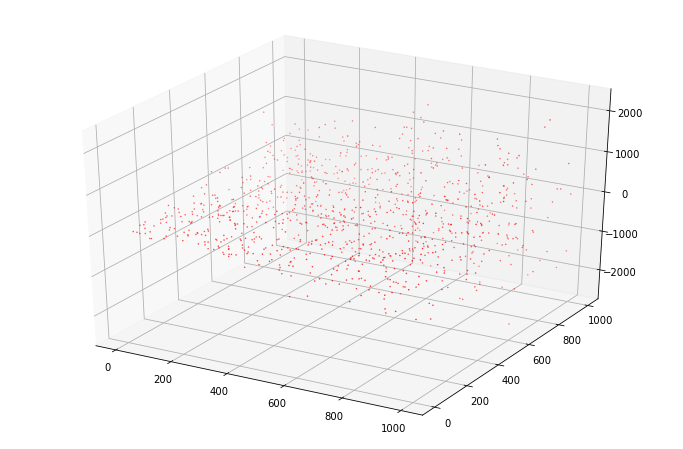

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_analytical['X1'], df_analytical['X2'], df_analytical['Y'], marker='.', color='r', s=1)
plt.show()

> The underlying analytical functions are planwaves, and we see an increase in noise as either X feature gets larger. We would like to reproduce this noise as uncertainty with our models.

In [5]:
## prepare the data as arrays
Xs = df_analytical[['X1', 'X2']].values
Ys = df_analytical['Y'].values.reshape(-1,1)
#. split into train and test
Xsr, Xst, Ysr, Yst = sklearn.model_selection.train_test_split(Xs, Ys, train_size=0.97)

#. scale and normalize our data
norm = sklearn.preprocessing.Normalizer()
scale = sklearn.preprocessing.StandardScaler()
Xsr = norm.fit_transform(Xsr)
Xst = norm.transform(Xst)
Ysr = scale.fit_transform(Ysr)
Yst = scale.transform(Yst)

***

We then instatialize and train our models on these datasets. All models are built on the same class framework so follow the same procedure.

## <span style="color:orange">Gaussian processes</span>

In [6]:
# instantialize the model
gp = gandy_gps.ucGaussianProcess.R(xshape=Xsr.shape[1:],
                                   yshape=Ysr.shape[1:])

In [7]:
# train it on the training data
gp.train(Xsr, Ysr)

In [8]:
# make predictions
gp_preds, gp_uncs = gp.predict(Xst)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


## <span style="color:orange"> Bayesian Neural Networks</span>

In [9]:
# instantialize the model
bnn = gandy_bnns.BNN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     train_size=len(Xsr))   # we must also pass the size of the training set, necessary for BNNs to weight the divergence

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [10]:
# train it on the training data
bnn.train(Xsr, Ysr, epochs=100)

Epoch 1/100
31/31 [==============================] - ETA: 1:41 - loss: 6.1322 - MSE: 2.372 - ETA: 0s - loss: 3.6479 - MSE: 1.5039  - ETA: 0s - loss: 3.4789 - MSE: 1.478 - ETA: 0s - loss: 3.4270 - MSE: 1.480 - 4s 6ms/step - loss: 3.3724 - MSE: 1.4792
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 1.3149 - MSE: 1.461 - ETA: 0s - loss: 1.7519 - MSE: 1.469 - ETA: 0s - loss: 1.9108 - MSE: 1.577 - 0s 5ms/step - loss: 1.9503 - MSE: 1.6188
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 2.9027 - MSE: 1.116 - ETA: 0s - loss: 2.0748 - MSE: 1.647 - ETA: 0s - loss: 2.1388 - MSE: 1.691 - 0s 5ms/step - loss: 2.1290 - MSE: 1.7263
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 1.7066 - MSE: 1.990 - ETA: 0s - loss: 1.5306 - MSE: 1.750 - ETA: 0s - loss: 1.6052 - MSE: 1.731 - ETA: 0s - loss: 1.6570 - MSE: 1.717 - 0s 6ms/step - loss: 1.6683 - MSE: 1.7260
Epoch 5/100
31/31 [==============================] - ETA: 0s - loss: 2.0670 - MSE: 1.611

31/31 [==============================] - ETA: 0s - loss: 1.4852 - MSE: 1.926 - ETA: 0s - loss: 1.5424 - MSE: 2.208 - ETA: 0s - loss: 1.5443 - MSE: 2.257 - ETA: 0s - loss: 1.5424 - MSE: 2.278 - 0s 6ms/step - loss: 1.5390 - MSE: 2.2880
Epoch 38/100
31/31 [==============================] - ETA: 0s - loss: 1.4107 - MSE: 1.546 - ETA: 0s - loss: 1.6514 - MSE: 1.956 - ETA: 0s - loss: 1.6009 - MSE: 2.124 - ETA: 0s - loss: 1.5831 - MSE: 2.228 - ETA: 0s - loss: 1.5786 - MSE: 2.253 - 0s 8ms/step - loss: 1.5766 - MSE: 2.2581
Epoch 39/100
31/31 [==============================] - ETA: 0s - loss: 1.4409 - MSE: 2.056 - ETA: 0s - loss: 1.4608 - MSE: 1.903 - ETA: 0s - loss: 1.4899 - MSE: 2.007 - ETA: 0s - loss: 1.4965 - MSE: 2.041 - 0s 7ms/step - loss: 1.4982 - MSE: 2.0503
Epoch 40/100
31/31 [==============================] - ETA: 0s - loss: 1.3809 - MSE: 2.013 - ETA: 0s - loss: 1.4054 - MSE: 1.892 - ETA: 0s - loss: 1.4369 - MSE: 1.952 - ETA: 0s - loss: 1.4499 - MSE: 1.991 - 0s 7ms/step - loss: 1.4559 -

31/31 [==============================] - ETA: 0s - loss: 1.4796 - MSE: 2.422 - ETA: 0s - loss: 1.4462 - MSE: 2.252 - ETA: 0s - loss: 1.4525 - MSE: 2.260 - ETA: 0s - loss: 1.4602 - MSE: 2.272 - ETA: 0s - loss: 1.4697 - MSE: 2.276 - 0s 8ms/step - loss: 1.4745 - MSE: 2.2763
Epoch 74/100
31/31 [==============================] - ETA: 0s - loss: 1.5360 - MSE: 2.327 - ETA: 0s - loss: 1.4155 - MSE: 1.923 - ETA: 0s - loss: 1.4337 - MSE: 2.054 - ETA: 0s - loss: 1.4541 - MSE: 2.173 - 0s 5ms/step - loss: 1.4551 - MSE: 2.1795
Epoch 75/100
31/31 [==============================] - ETA: 0s - loss: 1.5533 - MSE: 2.146 - ETA: 0s - loss: 1.5014 - MSE: 2.168 - ETA: 0s - loss: 1.4942 - MSE: 2.155 - 0s 4ms/step - loss: 1.4967 - MSE: 2.1537
Epoch 76/100
31/31 [==============================] - ETA: 0s - loss: 1.4833 - MSE: 1.766 - ETA: 0s - loss: 1.4347 - MSE: 1.906 - ETA: 0s - loss: 1.4545 - MSE: 2.033 - 0s 4ms/step - loss: 1.4582 - MSE: 2.0610
Epoch 77/100
31/31 [==============================] - ETA: 0s -

In [11]:
# make predictions
bnn_preds, bnn_uncs = bnn.predict(Xst)

## <span style="color:orange"> Generative Adversarial Networks</span>

In [12]:
# instantialize the model
gan = gandy_gans.GAN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     learning_rate=1e-4)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\gandy\models\dcgan.py:100: UserWarning: learning_rate must start with generator_ or discriminator_
Passing learning_rate as deepchem model init kwargs.
  " model init kwargs.")


In [13]:
# train it on the training data
gan.train(Xsr, Ysr, batches=10000)

Step 1000: 	Avg gen loss 0.7969508081674576, 	Avg discrim loss 1.2427107497453689
Step 2000: 	Avg gen loss 0.9031588916778565, 	Avg discrim loss 1.112270601093769
Step 3000: 	Avg gen loss 0.9668625839352608, 	Avg discrim loss 1.0517099679708481
Step 4000: 	Avg gen loss 1.0063097890615462, 	Avg discrim loss 1.0192858613729476
Step 5000: 	Avg gen loss 1.0305253271460533, 	Avg discrim loss 1.000765954375267
Step 6000: 	Avg gen loss 1.047137579679489, 	Avg discrim loss 0.991237489938736
Step 7000: 	Avg gen loss 1.0645515896081925, 	Avg discrim loss 0.97735983979702
Step 8000: 	Avg gen loss 1.073588980436325, 	Avg discrim loss 0.9712899815440178
Step 9000: 	Avg gen loss 1.0763293343782425, 	Avg discrim loss 0.9702168133854866
Step 10000: 	Avg gen loss 1.083452207803726, 	Avg discrim loss 0.964390584051609
TIMING: model fitting took 109.408 s


In [14]:
# make predictions
gan_preds, gan_uncs = gan.predict(Xst)

## <span style="color:orange"> Looking back at losses</span>

All of the models store any returned losses/metrics. These can be accessed at the `sessions` attribute for every training session, and additionally if the model accepts loss types other than default it can be specified to the model.

In [15]:
gan_losses = []
for key in gan.sessions.keys():
    gan_losses.append(gan.sessions[key])
    # only get one training session losses
    break
gan_losses = np.array(gan_losses[0])
gen_loss = gan_losses[0]
dis_loss = gan_losses[1]

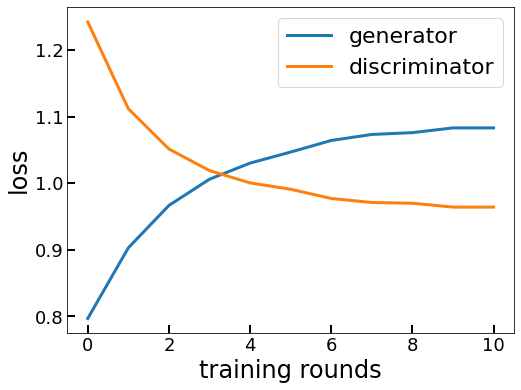

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

# plotting
ax.plot(gen_loss, linewidth=3, label='generator')
ax.plot(dis_loss, linewidth=3, label='discriminator')

# labels
ax.set_ylabel('loss', size=24)
ax.set_xlabel('training rounds', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

# legend
plt.legend(fontsize=22)

plt.show()

## <span style="color:orange"> Predictions</span>

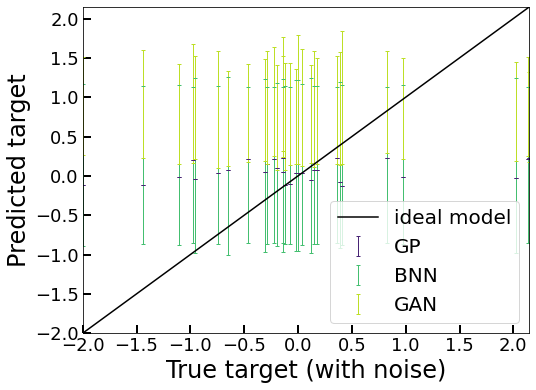

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])

# plot predictions of models
ax.errorbar(Yst, gp_preds, yerr=gp_uncs.reshape(-1), ls='none', label='GP', linewidth=1,
            capsize=2, c=Colors[0])
ax.errorbar(Yst, bnn_preds, yerr=bnn_uncs.reshape(-1), ls='none', label='BNN', linewidth=1,
            capsize=2, c=Colors[1])
ax.errorbar(Yst, gan_preds, yerr=gan_uncs.reshape(-1), ls='none', label='GAN', linewidth=1,
            capsize=2, c=Colors[2])

# perfect result
ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')

# labels
ax.set_ylabel('Predicted target', size=24)
ax.set_xlabel('True target (with noise)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

plt.legend(fontsize=20)
plt.show()

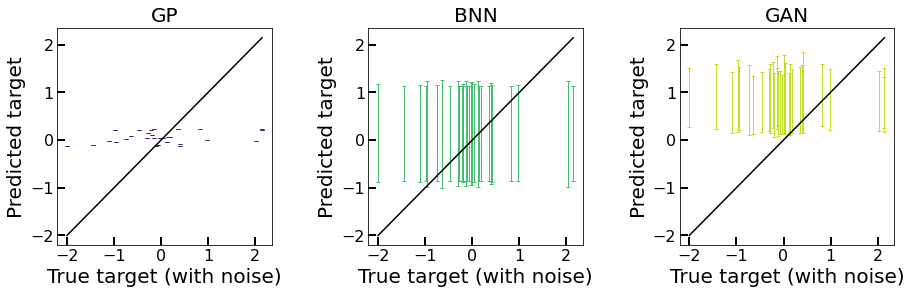

In [35]:
fig, axes = plt.subplots(figsize=(15,4), ncols=3)
fig.subplots_adjust(wspace=0.45)

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])
Preds = [gp_preds, bnn_preds, gan_preds]
Errs = [gp_uncs.reshape(-1), bnn_uncs.reshape(-1), gan_uncs.reshape(-1)]
Labels = ['GP', 'BNN', 'GAN']

# plot predictions of models
for i, ax in enumerate(axes):
    ax.errorbar(Yst, Preds[i], yerr=Errs[i], ls='none', label=Labels[i], linewidth=1,
            capsize=2, c=Colors[i])
    
    # perfect result
    ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')
    
    # labels
    ax.set_ylabel('Predicted target', size=20)
    ax.set_xlabel('True target (with noise)', size=20)

    # format ticks
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(direction='in', width=2, length=8)   

    ax.set_title(f'{Labels[i]}', fontsize=20)
    
plt.show()

All of the models at a galance to pretty poorly!

__GP__: The predicted values are mostly stationary. This is fairly expected given that we have only two features and a very nonlinear function. It also is predicting 0 uncertianty for most quantities.

__BNN__: Something seems very off here, the model predicts the same quantiy and uncertainty for all values.

__GAN__: The model seems to be on track knowing the fickyness of GANs. Also by the descriminator and generator losses diverging we can tell that we need to change some hyperparameters.

***

It might also be desireable to conduct hyperparameter search over a given model type's hyperparameters. This is achieved with the an optimization routine using [Optuna](https://github.com/optuna/optuna)'s code wrapped to fit our Uncertainty Model class.

## <span style="color:orange">Running a hyperparameter optimization</span>

Search for BNN hyperparameters - activation function and learning rate

In [18]:
# define the search space
search_space = {'activation': ['tanh', 'relu', 'sigmoid'],               # signifies a choice
                'optimizer_learning_rate': (0.001, 0.1, 'loguniform')}    # a continues lognormal sample space

# and the optimizing routine
opt = gandy_opt.OptRoutine(subject=gandy_bnns.BNN,
                           Xs=Xsr,
                           Ys=Ysr,
                           search_space=search_space,
                           xshape=Xsr.shape[1:],
                           yshape=Ysr.shape[1:],
                           train_size=len(Xsr))

In [19]:
# run the optimization
opt.optimize(n_trials=10)

TypeError: __init__() missing 1 required positional argument: 'param_space'

In [ ]:
## Code

***

Finally, we want to evaluate our model on its ability to predict uncertainty, such that future predictions of uncertainty are trusted.

In [ ]:
## Code

In [ ]:
## Code

In [ ]:
## Code